### This is a preparation of the DeepFM with Tensorflow

- Using the customized Tensorflow functions


### Consideration

- Model Considerations
  1. Initialization Method
     - Glorut
     - **He**
       - ReLu, LeakyReLu, Swish
  2. Activation Function
     - **ReLu**
       - Í≥ÑÏÇ∞ Î¶¨ÏÜåÏä§Í∞Ä Ï†úÌïúÎê† Îïå
     - **Leaky ReLu**
       - ReLuÍ∞Ä ÏÑ±Îä•Ïù¥ ÏïàÏ¢ãÏùÑÎïå
     - **Swish**
       - Í≥ÑÏÇ∞Îüâ ÎßéÏùÄÎç∞ ÏÑ±Îä•ÏùÄ Ï¢ãÏùå
  3. Batch Normalization
     - stablize the training
     - Apply between the hidden layer and the activation -> no need to apply the bias
  4. Gradient Clipping (opt)
  5. Optimizer
     - **Adam**
       - Í∏∞Î≥∏ ÏòµÏÖò
     - **AdamW**
       - Ïò§Î≤ÑÌîºÌåÖ Î∞©ÏßÄÏö©
       - l2 Îäî Î™ªÏì∞ÏßÄÎßå l1ÏùÄ ÏÇ¨Ïö© Í∞ÄÎä•
     - **Nadam**
       - Îπ†Î•∏ ÌõàÎ†®Ïù¥ ÌïÑÏöî Ìï† Îïå
  6. Learning Rate Scheduling
     - Performance Base
     - 1Cycle
  7. Custom Loss Function
     - CB-BCE + Ranking Loss
       - Class-Balanced Binary Cross-Entropy (CB-BCE):
         - ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Î¨∏Ï†úÎ•º Ìï¥Í≤∞ÌïòÍ∏∞ ÏúÑÌï¥ ÎùºÎ≤® ÎπàÎèÑÏóê Îî∞Îùº Í∞ÄÏ§ëÏπòÎ•º Ï†ÅÏö©.
       - Ranking Loss:
         - ÎùºÎ≤® Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ•º Î∞òÏòÅÌïòÏó¨, Ïò¨Î∞îÎ•∏ ÎùºÎ≤®Ïùò Ï†êÏàòÍ∞Ä ÏûòÎ™ªÎêú ÎùºÎ≤®Ïùò Ï†êÏàòÎ≥¥Îã§ ÎÜíÎèÑÎ°ù ÌïôÏäµ.


In [16]:
import tensorflow as tf
import numpy as np

# ------------------------------------------------------------------------------------
# 0. Ïª§Ïä§ÌÖÄ F1 Ïä§ÏΩîÏñ¥ Î©îÌä∏Î¶≠ Ï†ïÏùò
# ------------------------------------------------------------------------------------
class F1Score(tf.keras.metrics.Metric):
    """
    Ïù¥ ÌÅ¥ÎûòÏä§Îäî Ïù¥ÏßÑ Î©ÄÌã∞Î†àÏù¥Î∏î Î∂ÑÎ•ò Î¨∏Ï†úÏóêÏÑú Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌïòÍ∏∞ ÏúÑÌïú F1 Ïä§ÏΩîÏñ¥Î•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
    F1 Ïä§ÏΩîÏñ¥Îäî Ï†ïÎ∞ÄÎèÑ(Precision)ÏôÄ Ïû¨ÌòÑÏú®(Recall)Ïùò Ï°∞ÌôîÌèâÍ∑†ÏûÖÎãàÎã§.
    
    Ï£ºÏöî ÏÜçÏÑ±:
      - threshold: ÏòàÏ∏°Í∞íÏùÑ 1Î°ú ÌåêÎã®Ìï† Í∏∞Ï§Ä ÏûÑÍ≥ÑÍ∞íÏûÖÎãàÎã§.
      - true_positives: ÎàÑÏ†ÅÎêú True PositiveÏùò ÏàòÎ•º Ï†ÄÏû•Ìï©ÎãàÎã§.
      - false_positives: ÎàÑÏ†ÅÎêú False PositiveÏùò ÏàòÎ•º Ï†ÄÏû•Ìï©ÎãàÎã§.
      - false_negatives: ÎàÑÏ†ÅÎêú False NegativeÏùò ÏàòÎ•º Ï†ÄÏû•Ìï©ÎãàÎã§.
    """
    def __init__(self, threshold=0.5, name='f1_score', **kwargs):
        # Î∂ÄÎ™® ÌÅ¥ÎûòÏä§Ïùò Ï¥àÍ∏∞ÌôîÎ•º ÏàòÌñâÌï©ÎãàÎã§.
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        # Í∞Å Ïπ¥Ïö¥ÌÑ∞Î•º Ï¥àÍ∏∞Í∞í 0ÏúºÎ°ú ÏÑ§Ï†ïÌïòÍ≥†, Í∑∏ÎûòÌîÑÏóêÏÑú ÌïôÏäµ Ï§ë ÏóÖÎç∞Ïù¥Ìä∏ Ìï† Ïàò ÏûàÎèÑÎ°ù Î≥ÄÏàòÎ°ú Îì±Î°ùÌï©ÎãàÎã§.
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Î∞∞Ïπò Îã®ÏúÑÎ°ú Ìò∏Ï∂úÎêòÏñ¥ Ïã§Ï†ú Ï†ïÎãµ(y_true)Í≥º Î™®Îç∏ ÏòàÏ∏°(y_pred)ÏùÑ Î∞õÏïÑ
        Í∞Å ÏÉòÌîåÏóê ÎåÄÌïú True Positive, False Positive, False Negative Í∞íÏùÑ ÏóÖÎç∞Ïù¥Ìä∏ Ìï©ÎãàÎã§.
        
        Îß§Í∞úÎ≥ÄÏàò:
          - y_true: Ïã§Ï†ú Ï†ïÎãµ ÌÖêÏÑú (Ïã§Ï†ú Í∞íÏùÄ 0 ÎòêÎäî 1Î°ú Íµ¨ÏÑ±)
          - y_pred: Î™®Îç∏Ïùò ÏòàÏ∏°Í∞í ÌÖêÏÑú (Î≥¥ÌÜµ ÌôïÎ•† Í∞í, 0~1 ÏÇ¨Ïù¥)
          - sample_weight: Í∞Å ÏÉòÌîåÏóê Î∂ÄÏó¨Ìï† Í∞ÄÏ§ëÏπò(ÏòµÏÖò), Ï†úÍ≥µ Ïãú Í∞Å ÏÉòÌîåÎ≥Ñ Ï§ëÏöîÎèÑÎ•º Î∞òÏòÅÌï©ÎãàÎã§.
        """
        # ÏòàÏ∏°Í∞íÏùÑ threshold(Í∏∞Î≥∏Í∞í 0.5) Ïù¥ÏÉÅÏù¥Î©¥ 1, ÎØ∏ÎßåÏù¥Î©¥ 0ÏúºÎ°ú Ïù¥ÏßÑÌôîÌï©ÎãàÎã§.
        y_pred = tf.cast(tf.greater_equal(y_pred, self.threshold), tf.float32)
        # Ïã§Ï†ú Í∞íÎèÑ floatÌòïÏúºÎ°ú Î≥ÄÌôòÌïòÏó¨ Í≥ÑÏÇ∞Ïóê ÏùºÍ¥ÄÏÑ±ÏùÑ ÎßûÏ∂•ÎãàÎã§.
        y_true = tf.cast(y_true, tf.float32)
        
        # ÎßåÏïΩ sample_weightÍ∞Ä Ï†úÍ≥µÎêòÎ©¥, Í∞Å ÏÉòÌîåÏùò Í≤∞Í≥ºÏóê Ìï¥Îãπ Í∞ÄÏ§ëÏπòÎ•º Í≥±Ìï©ÎãàÎã§.
        if sample_weight is not None:
            # sample_weightÏùò Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖÏùÑ ÌòÑÏû¨ Î©îÌä∏Î¶≠Ïùò Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖÏúºÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
            sample_weight = tf.cast(sample_weight, self.dtype)
            # sample_weightÏùò Ï∞®ÏõêÏùÑ (Î∞∞Ïπò ÌÅ¨Í∏∞, 1)Î°ú Ïû¨Íµ¨ÏÑ±ÌïòÏó¨ y_trueÏôÄ y_predÏóê Ïò¨Î∞îÎ•¥Í≤å Î∏åÎ°úÎìúÏ∫êÏä§ÌåÖÌïòÎèÑÎ°ù Ìï©ÎãàÎã§.
            sample_weight = tf.reshape(sample_weight, (-1, 1))
            y_true = y_true * sample_weight
            y_pred = y_pred * sample_weight

        # True Positive: Ïã§Ï†ú 1Ïù¥Í≥† ÏòàÏ∏°ÎèÑ 1Ïù∏ Í≤ΩÏö∞Ïùò Ìï©ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
        tp = tf.reduce_sum(y_true * y_pred)
        # False Positive: Ïã§Ï†ú 0Ïù¥ÏßÄÎßå ÏòàÏ∏°ÏùÄ 1Ïù∏ Í≤ΩÏö∞Ïùò Ìï©ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        # False Negative: Ïã§Ï†ú 1Ïù∏Îç∞ ÏòàÏ∏°ÏùÄ 0Ïù∏ Í≤ΩÏö∞Ïùò Ìï©ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        # ÎàÑÏ†Å Í∞íÏóê ÌòÑÏû¨ Î∞∞ÏπòÏùò tp, fp, fn Í∞íÏùÑ ÎçîÌï©ÎãàÎã§.
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        """
        ÌòÑÏû¨ÍπåÏßÄ ÎàÑÏ†ÅÎêú True Positive, False Positive, False NegativeÎ•º Î∞îÌÉïÏúºÎ°ú 
        Ï†ïÎ∞ÄÎèÑ, Ïû¨ÌòÑÏú®, Í∑∏Î¶¨Í≥† ÏµúÏ¢Ö F1 Ïä§ÏΩîÏñ¥Î•º Í≥ÑÏÇ∞ÌïòÏó¨ Î∞òÌôòÌï©ÎãàÎã§.
        """
        # Ï†ïÎ∞ÄÎèÑ: Ïã§Ï†ú ÏòàÏ∏°Îêú ÏñëÏÑ± Ï§ëÏóêÏÑú Ïã§Ï†ú ÏñëÏÑ±Ïù∏ ÎπÑÏú®
        precision = self.true_positives / (
            self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        # Ïû¨ÌòÑÏú®: Ïã§Ï†ú ÏñëÏÑ± Ï§ëÏóêÏÑú Ï†ïÌôïÌïòÍ≤å ÏòàÏ∏°Îêú ÎπÑÏú®
        recall = self.true_positives / (
            self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        # F1 Ïä§ÏΩîÏñ¥: Ï†ïÎ∞ÄÎèÑÏôÄ Ïû¨ÌòÑÏú®Ïùò Ï°∞ÌôîÌèâÍ∑†
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        """
        ÌèâÍ∞ÄÍ∞Ä ÏôÑÎ£åÎêú ÌõÑ ÎòêÎäî ÏÉàÎ°úÏö¥ ÌèâÍ∞Ä Ï£ºÍ∏∞ ÏãúÏûë Ïãú ÎàÑÏ†ÅÎêú Í∞íÏùÑ 0ÏúºÎ°ú Ï¥àÍ∏∞ÌôîÌï©ÎãàÎã§.
        """
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


# ------------------------------------------------------------------------------------
# 1. ÎùºÎ≤® Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ Ìï®Ïàò (Median Frequency Balancing)
# ------------------------------------------------------------------------------------
def compute_label_weights(label_counts: dict) -> tf.Tensor:
    """
    Í∞Å ÎùºÎ≤®Ïùò Îì±Ïû• ÎπàÎèÑÏàòÎ•º Î∞îÌÉïÏúºÎ°ú ÎùºÎ≤®Î≥Ñ Í∞ÄÏ§ëÏπòÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
    Ïó¨Í∏∞ÏÑú Í∞ÄÏ§ëÏπòÎäî Í∞Å ÎùºÎ≤®Ïùò ÎπàÎèÑÏóê Îî∞Îùº Í≥ÑÏÇ∞ÎêòÎ©∞, Í∞íÏù¥ Ï†ÅÏùÄ ÎùºÎ≤®Ïóê Îçî ÎÜíÏùÄ Í∞ÄÏ§ëÏπòÎ•º Î∂ÄÏó¨Ìï©ÎãàÎã§.
    
    Í≥ÑÏÇ∞Ïãù:
        weight = (Î™®Îì† ÎùºÎ≤®Ïùò Îì±Ïû• ÎπàÎèÑÏùò Ï§ëÏïôÍ∞í) / (Ìï¥Îãπ ÎùºÎ≤®Ïùò Îì±Ïû• ÎπàÎèÑ)
    
    Îß§Í∞úÎ≥ÄÏàò:
      - label_counts: Í∞Å ÎùºÎ≤®Í≥º Ìï¥Îãπ ÎùºÎ≤®Ïùò Îì±Ïû• ÎπàÎèÑÎ•º Îã¥ÏùÄ ÎîïÏÖîÎÑàÎ¶¨ (Ïòà: {"label": 100})
    
    Î∞òÌôò:
      - ÏïåÌååÎ≤≥ ÏàúÏúºÎ°ú Ï†ïÎ†¨Îêú ÎùºÎ≤®Ïóê Ìï¥ÎãπÌïòÎäî Í∞ÄÏ§ëÏπò ÌÖêÏÑú (tf.float32)
    """
    # ÎîïÏÖîÎÑàÎ¶¨Ïùò valueÎì§ÏùÑ numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôòÌï©ÎãàÎã§.
    counts = np.array(list(label_counts.values()), dtype=np.float32)
    # ÎßåÏïΩ Ïñ¥Îñ§ ÎùºÎ≤®Ïùò countÍ∞Ä 0Ïù¥Î©¥ 0ÏúºÎ°ú ÎÇòÎàÑÎäî Ïò§Î•òÍ∞Ä Î∞úÏÉùÌï† Ïàò ÏûàÏúºÎØÄÎ°ú, 0Ïù∏ Í≤ΩÏö∞ 1.0ÏúºÎ°ú ÏπòÌôòÌï©ÎãàÎã§.
    counts[counts == 0] = 1.0
    # Î™®Îì† countÏùò Ï§ëÏïôÍ∞íÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
    median_count = np.median(counts)
    # Í∞Å ÎùºÎ≤®Ïóê ÎåÄÌï¥ (Ï§ëÏïôÍ∞í / count)Î•º Í≥ÑÏÇ∞ÌïòÏó¨ Í∞ÄÏ§ëÏπò ÎîïÏÖîÎÑàÎ¶¨Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§.
    weights = {label: median_count / count for label, count in label_counts.items()}
    # ÎùºÎ≤®Ïùò ÏàúÏÑúÎ•º ÏïåÌååÎ≤≥ ÏàúÏúºÎ°ú Ï†ïÎ†¨ÌïòÏó¨ ÏùºÍ¥ÄÎêú ÏàúÏÑúÎ•º Ïú†ÏßÄÌï©ÎãàÎã§.
    sorted_labels = sorted(label_counts.keys())
    # Ï†ïÎ†¨Îêú ÎùºÎ≤® ÏàúÏÑúÎåÄÎ°ú Í∞ÄÏ§ëÏπò Í∞íÏùÑ Î¶¨Ïä§Ìä∏Î°ú ÏÉùÏÑ±Ìï©ÎãàÎã§.
    weights_list = [weights[label] for label in sorted_labels]
    # Î¶¨Ïä§Ìä∏Î•º ÌÖêÏÑúÎ°ú Î≥ÄÌôòÌïòÏó¨ Î∞òÌôòÌï©ÎãàÎã§.
    return tf.constant(weights_list, dtype=tf.float32)


# ------------------------------------------------------------------------------------
# 2. DeepFM Î™®Îç∏ ÌÅ¥ÎûòÏä§ (ÏàòÏπòÌòï ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Ïö©)
# ------------------------------------------------------------------------------------
class DeepFMModel(tf.keras.Model):
    """
    DeepFM Î™®Îç∏ÏùÄ ÏÑ†Ìòï(Linear), Ìå©ÌÑ∞Ìôî Î®∏Ïã†(FM), Í∑∏Î¶¨Í≥† Îî•Îü¨Îãù(Deep) ÏÑ∏ ÌååÌä∏Î•º Í≤∞Ìï©ÌïòÏó¨
    ÏûÖÎ†•Îêú ÏàòÏπòÌòï Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î∞òÏúºÎ°ú Ïù¥ÏßÑ Î∂ÑÎ•òÎ•º ÏàòÌñâÌï©ÎãàÎã§.
    
    Íµ¨ÏÑ± ÏöîÏÜå:
      1. Linear ÌååÌä∏: Îã®Ïàú ÏÑ†Ìòï Î≥ÄÌôòÏùÑ Ï†ÅÏö©ÌïòÏó¨ Í∞Å ÌîºÏ≤òÏùò ÏßÅÏ†ëÏ†ÅÏù∏ ÏòÅÌñ•Î†•ÏùÑ Î™®Îç∏ÎßÅÌï©ÎãàÎã§.
      2. FM ÌååÌä∏: Í∞Å ÌîºÏ≤òÎßàÎã§ ÌïôÏäµ Í∞ÄÎä•Ìïú ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Î•º Ïù¥Ïö©ÌïòÏó¨ 2Ï∞® ÏÉÅÌò∏ÏûëÏö© Ìö®Í≥º(ÌîºÏ≤òÍ∞Ñ Í≥±ÏÖà Ìï≠)Î•º Î™®Îç∏ÎßÅÌï©ÎãàÎã§.
      3. Deep ÌååÌä∏: Îã§Ï∏µ ÌçºÏÖâÌä∏Î°†(MLP)ÏùÑ ÌÜµÌï¥ ÏûÖÎ†• ÌîºÏ≤òÏùò ÎπÑÏÑ†Ìòï ÏÉÅÌò∏ÏûëÏö©ÏùÑ ÌïôÏäµÌï©ÎãàÎã§.
    
    ÏµúÏ¢Ö Ï∂úÎ†•ÏùÄ ÏÑ∏ ÌååÌä∏Ïùò Í≤∞Í≥ºÎ•º Ìï©ÏÇ∞Ìïú ÌõÑ, sigmoid Ìï®ÏàòÎ•º ÌÜµÌï¥ 0~1 ÏÇ¨Ïù¥Ïùò ÌôïÎ•† Í∞íÏúºÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
    """
    def __init__(self, num_features: int, embedding_dim: int, num_labels: int,
                 deep_units: list, dropout_rate: float = 0.5, l2_reg: float = 1e-4, **kwargs):
        # Î∂ÄÎ™® ÌÅ¥ÎûòÏä§(tf.keras.Model)Î•º Ï¥àÍ∏∞ÌôîÌï©ÎãàÎã§.
        super(DeepFMModel, self).__init__(**kwargs)
        self.num_features = num_features  # ÏûÖÎ†• ÌîºÏ≤òÏùò Í∞úÏàò (Ïòà: 7)
        
        # ----- Linear ÌååÌä∏ -----
        # ÏàòÏπòÌòï ÏûÖÎ†•Ïóê ÎåÄÌï¥ Îã®Ïàú ÏÑ†Ìòï Î≥ÄÌôòÏùÑ ÏàòÌñâÌïòÎäî Dense Î†àÏù¥Ïñ¥ÏûÖÎãàÎã§.
        # Í∞Å ÌîºÏ≤òÏóê ÎåÄÌï¥ ÏÑ†Ìòï Í∞ÄÏ§ëÏπòÎ•º ÌïôÏäµÌïòÏó¨ ÏßÅÏ†ëÏ†ÅÏù∏ ÏòÅÌñ•Î†•ÏùÑ Î™®Îç∏ÎßÅÌï©ÎãàÎã§.
        self.linear_dense = tf.keras.layers.Dense(
            units=num_labels,  # Ï∂úÎ†• Ï∞®Ïõê: ÏòàÏ∏°Ìï† ÎùºÎ≤®Ïùò Ïàò (Ïòà: 1)
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),  # Í≥ºÏ†ÅÌï© Î∞©ÏßÄÎ•º ÏúÑÌïú L2 Ï†ïÍ∑úÌôî Ï†ÅÏö©
            name="linear_dense"
        )
        
        # ----- FM ÌååÌä∏ -----
        # Í∞Å ÌîºÏ≤òÏóê ÎåÄÌï¥ ÌïôÏäµ Í∞ÄÎä•Ìïú ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§.
        # ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Ïùò Ï∞®ÏõêÏùÄ embedding_dimÏù¥Î©∞, Í∞Å ÌîºÏ≤òÏùò Í∞íÍ≥º Í≥±Ìï¥Ï†∏ÏÑú 2Ï∞® ÏÉÅÌò∏ÏûëÏö©ÏùÑ Í≥ÑÏÇ∞ÌïòÎäî Îç∞ ÏÇ¨Ïö©Îê©ÎãàÎã§.
        self.feature_embedding = self.add_weight(
            name="feature_embedding",
            shape=(num_features, embedding_dim),  # (ÌîºÏ≤ò Í∞úÏàò, ÏûÑÎ≤†Îî© Ï∞®Ïõê)
            initializer=tf.keras.initializers.GlorotUniform(),  # Í∞ÄÏ§ëÏπò Ï¥àÍ∏∞Ìôî Î∞©Ïãù
            regularizer=tf.keras.regularizers.l2(l2_reg)  # L2 Ï†ïÍ∑úÌôî Ï†ÅÏö©
        )
        # FM ÏÉÅÌò∏ÏûëÏö© Í≤∞Í≥ºÎ•º num_labels Ï∞®ÏõêÏúºÎ°ú Î≥ÄÌôòÌïòÎäî Dense Î†àÏù¥Ïñ¥ÏûÖÎãàÎã§.
        self.fm_dense = tf.keras.layers.Dense(
            units=num_labels,
            kernel_initializer=tf.keras.initializers.HeNormal(),  # He Ï¥àÍ∏∞Ìôî Ï†ÅÏö©
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            name="fm_dense"
        )
        
        # ----- Deep ÌååÌä∏ -----
        # ÏàòÏπòÌòï ÏûÖÎ†•ÏùÑ Í∑∏ÎåÄÎ°ú MLP(Îã§Ï∏µ ÌçºÏÖâÌä∏Î°†)Ïóê ÌÜµÍ≥ºÏãúÏºú ÎπÑÏÑ†Ìòï ÌäπÏÑ±ÏùÑ ÌïôÏäµÌï©ÎãàÎã§.
        # Sequential Î™®Îç∏ÏùÑ Ïù¥Ïö©ÌïòÏó¨ Ïó¨Îü¨ Í∞úÏùò Dense Î∞è Dropout Î†àÏù¥Ïñ¥Î•º ÏàúÏ∞®Ï†ÅÏúºÎ°ú Íµ¨ÏÑ±Ìï©ÎãàÎã§.
        self.deep_layers = tf.keras.Sequential(name="deep_sequential")
        for i, units in enumerate(deep_units):
            # Ï≤´ Î≤àÏß∏ Dense Î†àÏù¥Ïñ¥: ÏùÄÎãâÏ∏µÏùò Îâ¥Îü∞ ÏàòÎäî deep_units Î¶¨Ïä§Ìä∏Ïóê ÏùòÌï¥ Í≤∞Ï†ïÎê©ÎãàÎã§.
            self.deep_layers.add(
                tf.keras.layers.Dense(
                    units=units,
                    activation='relu',  # ÌôúÏÑ±Ìôî Ìï®ÏàòÎ°ú ReLU ÏÇ¨Ïö©
                    kernel_initializer=tf.keras.initializers.HeNormal(),
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                    name=f"deep_dense_{i}"
                )
            )
            # Dropout Î†àÏù¥Ïñ¥Î•º Ï∂îÍ∞ÄÌïòÏó¨ Í≥ºÏ†ÅÌï©ÏùÑ Î∞©ÏßÄÌï©ÎãàÎã§.
            self.deep_layers.add(
                tf.keras.layers.Dropout(rate=dropout_rate, name=f"deep_dropout_{i}")
            )
        # Deep ÌååÌä∏Ïùò ÎßàÏßÄÎßâ Ï∂úÎ†• Î†àÏù¥Ïñ¥: ÏµúÏ¢Ö Ï∂úÎ†• Ï∞®ÏõêÏùÄ num_labelsÏûÖÎãàÎã§.
        self.deep_output = tf.keras.layers.Dense(
            units=num_labels,
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            name="deep_output"
        )
    
    @tf.function
    def call(self, inputs, training=False):
        """
        Î™®Îç∏Ïùò ÏàúÏ†ÑÌåå(forward propagation) Í≥ºÏ†ïÏùÑ Ï†ïÏùòÌï©ÎãàÎã§.
        
        Îß§Í∞úÎ≥ÄÏàò:
          - inputs: (batch_size, num_features) ÌòïÌÉúÏùò ÏûÖÎ†• ÌÖêÏÑú
          - training: ÌïôÏäµ Î™®Îìú Ïó¨Î∂Ä (Dropout Îì± Î†àÏù¥Ïñ¥Ïùò ÎèôÏûëÏóê ÏòÅÌñ•ÏùÑ Ï§å)
          
        Î∞òÌôò:
          - sigmoid Ìï®ÏàòÎ•º Ï†ÅÏö©Ìïú ÏµúÏ¢Ö ÏòàÏ∏° ÌôïÎ•†Í∞í (batch_size, num_labels)
        """
        # [Linear ÌååÌä∏]
        # ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Î•º Îã®Ïàú ÏÑ†Ìòï Î≥ÄÌôòÌïòÏó¨ Í∞Å ÌîºÏ≤òÏùò Í∞ÄÏ§ëÏπò Í≥±Ïùò Ìï©ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
        # Í≤∞Í≥º ÌÖêÏÑú shape: (batch_size, num_labels)
        linear_out = self.linear_dense(inputs)
        
        # [FM ÌååÌä∏]
        # FM ÌååÌä∏ÏóêÏÑúÎäî Í∞Å ÌîºÏ≤òÏùò Í∞íÍ≥º Ìï¥Îãπ ÌîºÏ≤òÏóê ÎåÄÏùëÌïòÎäî ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Ïùò Í≥±ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
        # 1. ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Î•º (batch_size, num_features, 1) ÌòïÌÉúÎ°ú ÌôïÏû•ÌïòÏó¨ Í∞Å ÌîºÏ≤òÏóê ÎåÄÌïú Î≥ÑÎèÑ Ï∞®ÏõêÏùÑ ÎßåÎì≠ÎãàÎã§.
        x_expanded = tf.expand_dims(inputs, axis=-1)
        # 2. Î∏åÎ°úÎìúÏ∫êÏä§ÌåÖÏùÑ Ïù¥Ïö©Ìï¥ Í∞Å ÌîºÏ≤òÏùò Í∞íÍ≥º ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Î•º Í≥±Ìï©ÎãàÎã§.
        #    Í≤∞Í≥º ÌÖêÏÑú shape: (batch_size, num_features, embedding_dim)
        fm_embeddings = x_expanded * self.feature_embedding
        # 3. Í∞Å ÌîºÏ≤ò ÏûÑÎ≤†Îî©ÏùÑ Î™®Îëê Ìï©ÏÇ∞ÌïòÏó¨, ÌîºÏ≤òÍ∞Ñ ÏÉÅÌò∏ÏûëÏö©ÏùÑ Î∞òÏòÅÌïòÎäî Î≤°ÌÑ∞Î•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
        #    summed_embeddingsÏùò shape: (batch_size, embedding_dim)
        summed_embeddings = tf.reduce_sum(fm_embeddings, axis=1)
        # 4. Ìï©ÏÇ∞Ìïú ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Ïùò Ï†úÍ≥±ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
        squared_sum = tf.square(summed_embeddings)
        # 5. Í∞Å ÌîºÏ≤ò ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Î•º Ï†úÍ≥±Ìïú ÌõÑ, Ìï©ÏÇ∞Ìï©ÎãàÎã§.
        squared_embeddings = tf.square(fm_embeddings)
        sum_squared = tf.reduce_sum(squared_embeddings, axis=1)
        # 6. FMÏùò 2Ï∞® ÏÉÅÌò∏ÏûëÏö© Ìö®Í≥º Í≥ÑÏÇ∞ Í≥µÏãù Ï†ÅÏö©:
        #    0.5 * ((sum of embeddings)^2 - sum of (squared embeddings))
        fm_interactions = 0.5 * (squared_sum - sum_squared)
        # 7. FM ÏÉÅÌò∏ÏûëÏö© Í≤∞Í≥ºÎ•º Dense Î†àÏù¥Ïñ¥Î•º ÌÜµÌï¥ ÏµúÏ¢Ö Ï∂úÎ†• Ï∞®Ïõê(num_labels)ÏúºÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
        fm_out = self.fm_dense(fm_interactions)
        
        # [Deep ÌååÌä∏]
        # ÏõêÎ≥∏ ÏàòÏπòÌòï ÏûÖÎ†•ÏùÑ Í∑∏ÎåÄÎ°ú Îã§Ï∏µ ÌçºÏÖâÌä∏Î°†(MLP)Ïóê Ï†ÑÎã¨ÌïòÏó¨ ÎπÑÏÑ†Ìòï ÌäπÏÑ±ÏùÑ ÌïôÏäµÌï©ÎãàÎã§.
        deep_out = self.deep_layers(inputs, training=training)
        # Deep ÌååÌä∏Ïùò ÎßàÏßÄÎßâ Ï∂úÎ†• Î†àÏù¥Ïñ¥Î•º ÌÜµÍ≥ºÌïòÏó¨ ÏµúÏ¢Ö Í≤∞Í≥ºÎ•º ÏñªÏäµÎãàÎã§.
        deep_out = self.deep_output(deep_out)
        
        # ÏÑ∏ ÌååÌä∏Ïùò Ï∂úÎ†•ÏùÑ Ìï©ÏÇ∞Ìï©ÎãàÎã§.
        logits = linear_out + fm_out + deep_out
        # Ìï©ÏÇ∞Îêú Í≤∞Í≥ºÏóê sigmoid Ìï®ÏàòÎ•º Ï†ÅÏö©ÌïòÏó¨ 0Í≥º 1 ÏÇ¨Ïù¥Ïùò ÌôïÎ•† Í∞íÏúºÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
        outputs = tf.keras.activations.sigmoid(logits)
        return outputs


# ------------------------------------------------------------------------------------
# 3. ÏÇ¨Ïö©Ïûê Ï†ïÏùò ÏÜêÏã§ Ìï®Ïàò (Í∞ÄÏ§ëÏπò Ï†ÅÏö© Ïù¥ÏßÑ ÌÅ¨Î°úÏä§ÏóîÌä∏Î°úÌîº)
# ------------------------------------------------------------------------------------
def weighted_binary_crossentropy(label_weights: tf.Tensor):
    """
    ÎùºÎ≤®Î≥Ñ Í∞ÄÏ§ëÏπòÎ•º Ï†ÅÏö©Ìïú Ïù¥ÏßÑ ÌÅ¨Î°úÏä§ÏóîÌä∏Î°úÌîº ÏÜêÏã§ Ìï®ÏàòÎ•º ÏÉùÏÑ±Ìï©ÎãàÎã§.
    
    Ìï®Ïàò ÎÇ¥Î∂ÄÏóêÏÑúÎäî Í∞Å ÎùºÎ≤®Ïóê ÎåÄÌï¥ ÎØ∏Î¶¨ Í≥ÑÏÇ∞Îêú Í∞ÄÏ§ëÏπòÎ•º Í≥±Ìïú ÌõÑ, Ï†ÑÏ≤¥ ÏÉòÌîåÏùò ÌèâÍ∑† ÏÜêÏã§ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
    
    Îß§Í∞úÎ≥ÄÏàò:
      - label_weights: Í∞Å ÎùºÎ≤®Ïóê ÎåÄÌïú Í∞ÄÏ§ëÏπòÎ•º Îã¥ÏùÄ ÌÖêÏÑú (Ïòà: [Í∞ÄÏ§ëÏπò1, Í∞ÄÏ§ëÏπò2, ...])
    
    Î∞òÌôò:
      - ÏÜêÏã§ Ìï®Ïàò (loss function) that accepts y_trueÏôÄ y_pred
    """
    def loss_fn(y_true, y_pred):
        # label_weightsÏùò shapeÏùÑ (1, num_labels)Î°ú Ïû¨Íµ¨ÏÑ±ÌïòÏó¨ y_true, y_predÏóê Î∏åÎ°úÎìúÏ∫êÏä§ÌåÖÌï©ÎãàÎã§.
        lw = tf.reshape(label_weights, [1, -1])
        # Í∏∞Î≥∏ Ïù¥ÏßÑ ÌÅ¨Î°úÏä§ÏóîÌä∏Î°úÌîº ÏÜêÏã§ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Í∞Å ÎùºÎ≤®Ïóê ÎåÄÌï¥ Í∞ÄÏ§ëÏπòÎ•º Í≥±ÌïòÏó¨ ÏÜêÏã§ Í∞íÏùÑ Ï°∞Ï†ïÌï©ÎãàÎã§.
        weighted_bce = bce * lw
        # Ï†ÑÏ≤¥ Î∞∞ÏπòÏóê ÎåÄÌï¥ ÌèâÍ∑† ÏÜêÏã§ÏùÑ Í≥ÑÏÇ∞ÌïòÏó¨ Î∞òÌôòÌï©ÎãàÎã§.
        return tf.reduce_mean(weighted_bce)
    return loss_fn


# ------------------------------------------------------------------------------------
# 4. ÏòµÌã∞ÎßàÏù¥Ï†Ä Î∞è ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨ Ï†ïÏùò
# ------------------------------------------------------------------------------------
def get_optimizer(initial_lr: float = 1e-3) -> tf.keras.optimizers.Optimizer:
    """
    ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨(ExponentialDecay)Î•º ÏÇ¨Ïö©ÌïòÏó¨ Ï†êÏßÑÏ†ÅÏúºÎ°ú ÌïôÏäµÎ•†ÏùÑ Í∞êÏÜåÏãúÌÇ§Í≥†,
    Adam ÏòµÌã∞ÎßàÏù¥Ï†ÄÎ•º Î∞òÌôòÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§.
    
    Îß§Í∞úÎ≥ÄÏàò:
      - initial_lr: Ï¥àÍ∏∞ ÌïôÏäµÎ•† (default: 0.001)
    
    Î∞òÌôò:
      - Adam ÏòµÌã∞ÎßàÏù¥Ï†Ä Í∞ùÏ≤¥ (tf.keras.optimizers.Optimizer)
    """
    # ExponentialDecay Ïä§ÏºÄÏ§ÑÎü¨Î•º ÏÉùÏÑ±ÌïòÏó¨, Îß§ decay_stepsÎßàÎã§ ÌïôÏäµÎ•†ÏùÑ decay_rate ÎßåÌÅº Í∞êÏÜåÏãúÌÇµÎãàÎã§.
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=10000,   # ÌïôÏäµÎ•†Ïù¥ Í∞êÏÜåÌïòÍ∏∞ Ï†Ñ Î™á Ïä§ÌÖùÎßàÎã§ ÏóÖÎç∞Ïù¥Ìä∏Ìï†ÏßÄÎ•º ÏßÄÏ†ïÌï©ÎãàÎã§.
        decay_rate=0.96,     # Îß§ ÏóÖÎç∞Ïù¥Ìä∏ Ïãú ÌïôÏäµÎ•†Ïóê Í≥±Ìï¥Ïßà ÎπÑÏú®
        staircase=True       # Í≥ÑÎã®Ìòï Í∞êÏÜåÎ•º ÏÇ¨Ïö© (Îß§ ÏùºÏ†ï Ïä§ÌÖùÎßàÎã§ ÌïôÏäµÎ•†ÏùÑ Îñ®Ïñ¥Îú®Î¶º)
    )
    # Adam ÏòµÌã∞ÎßàÏù¥Ï†ÄÏóê ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨Î•º Ï†ÅÏö©ÌïòÏó¨ Î∞òÌôòÌï©ÎãàÎã§.
    return tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# ------------------------------------------------------------------------------------
# 5. ÌîÑÎ°úÎçïÏÖòÏö© ÌïôÏäµ ÏòàÏãú
# ------------------------------------------------------------------------------------
if __name__ == "__main__":
    # -----------------------------
    # 1) ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
    # -----------------------------
    num_features = 7       # ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Ïùò ÌîºÏ≤ò Í∞úÏàò (Ïòà: 7Í∞ú)
    num_labels = 1         # ÏòàÏ∏°Ìï† ÎùºÎ≤®Ïùò Ïàò (Ïó¨Í∏∞ÏÑúÎäî Ïù¥ÏßÑ Î∂ÑÎ•òÏù¥ÎØÄÎ°ú 1)
    embedding_dim = 8      # FM ÌååÌä∏ÏóêÏÑú Í∞Å ÌîºÏ≤òÎ•º ÏûÑÎ≤†Îî©Ìï† Ï∞®Ïõê (Ïòà: 8)
    deep_units = [64, 32]  # Deep ÌååÌä∏ MLPÏùò ÏùÄÎãâÏ∏µ Îâ¥Îü∞ Ïàò Î¶¨Ïä§Ìä∏ (Ï≤´ Î≤àÏß∏ Ï∏µ 64Í∞ú, Îëê Î≤àÏß∏ Ï∏µ 32Í∞ú)
    dropout_rate = 0.5     # Dropout ÎπÑÏú® (Í≥ºÏ†ÅÌï© Î∞©ÏßÄ)
    l2_reg = 1e-4          # L2 Ï†ïÍ∑úÌôî Í≥ÑÏàò (Í≥ºÏ†ÅÌï© Î∞©ÏßÄ)
    
    # -----------------------------
    # 2) ÎùºÎ≤® Îì±Ïû• ÎπàÎèÑ Í∏∞Î∞ò Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
    # -----------------------------
    # ÏòàÎ•º Îì§Ïñ¥, "label"Ïù¥ÎùºÎäî ÎùºÎ≤®Ïùò Îì±Ïû• ÎπàÎèÑÍ∞Ä 100Î≤àÏù¥ÎùºÎ©¥,
    # Median Frequency BalancingÏùÑ Ï†ÅÏö©ÌïòÏó¨ Í∞ÄÏ§ëÏπòÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
    label_counts = {"label": 100}
    label_weights = compute_label_weights(label_counts)
    
    # -----------------------------
    # 3) Î™®Îç∏ ÏÉùÏÑ± Î∞è Ïª¥ÌååÏùº
    # -----------------------------
    # DeepFM Î™®Îç∏ Í∞ùÏ≤¥Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§.
    # ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Îäî (batch_size, num_features) ÌòïÌÉúÏùò ÏàòÏπòÌòï Î≤°ÌÑ∞ÏûÖÎãàÎã§.
    model = DeepFMModel(num_features, embedding_dim, num_labels, deep_units,
                        dropout_rate=dropout_rate, l2_reg=l2_reg)
    # ÏòµÌã∞ÎßàÏù¥Ï†ÄÎ•º ÏÑ§Ï†ïÌï©ÎãàÎã§.
    optimizer = get_optimizer(initial_lr=1e-3)
    # Î™®Îç∏ Ïª¥ÌååÏùº: ÏòµÌã∞ÎßàÏù¥Ï†Ä, ÏÇ¨Ïö©Ïûê Ï†ïÏùò ÏÜêÏã§ Ìï®Ïàò, ÌèâÍ∞Ä ÏßÄÌëú(Ï†ïÌôïÎèÑ, F1, AUC)Î•º ÏÑ§Ï†ïÌï©ÎãàÎã§.
    model.compile(
        optimizer=optimizer,
        loss=weighted_binary_crossentropy(label_weights),
        metrics=["accuracy", F1Score(threshold=0.5), tf.keras.metrics.AUC(name="auc")]
    )
    
    # Î™®Îç∏Ïùò ÏûÖÎ†• ÌòïÌÉúÎ•º ÏßÄÏ†ïÌïòÏó¨ ÎπåÎìúÌï©ÎãàÎã§. (None: Î∞∞Ïπò ÌÅ¨Í∏∞Îäî Ïú†ÎèôÏ†Å, num_features: 7)
    model.build(input_shape=(None, num_features))
    # Î™®Îç∏ Íµ¨Ï°∞ ÏöîÏïΩÏùÑ Ï∂úÎ†•Ìï©ÎãàÎã§.
    model.summary()
    
    # -----------------------------
    # 4) ÎçîÎØ∏ Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
    # -----------------------------
    # Ïã§Ï†ú ÌïôÏäµÏóêÏÑúÎäî Ï†ÅÏ†àÌïú train/validation Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÏÇ¨Ïö©Ìï¥Ïïº ÌïòÏßÄÎßå,
    # Ïó¨Í∏∞ÏÑúÎäî ÏòàÏãúÎ•º ÏúÑÌï¥ ÏûÑÏùòÏùò ÏàòÏπòÌòï Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§.
    num_samples = 1000  # Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò
    # Í∞Å ÌîºÏ≤ò Í∞íÏùÄ 0~1 ÏÇ¨Ïù¥Ïùò ÎûúÎç§ Ïã§Ïàò Í∞íÏúºÎ°ú ÏÉùÏÑ± (Ï†ïÍ∑úÌôîÎêú Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†ï)
    X_dummy = np.random.random(size=(num_samples, num_features)).astype(np.float32)
    # Ïù¥ÏßÑ ÎùºÎ≤® (0 ÎòêÎäî 1)ÏùÑ ÏûÑÏùòÎ°ú ÏÉùÏÑ±ÌïòÏó¨ shape: (num_samples, num_labels)
    y_dummy = np.random.randint(0, 2, size=(num_samples, num_labels)).astype(np.float32)
    batch_size = 32  # Î∞∞Ïπò ÌÅ¨Í∏∞ ÏÑ§Ï†ï
    # tf.data.DatasetÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Îç∞Ïù¥ÌÑ∞Î•º Ìö®Ïú®Ï†ÅÏúºÎ°ú Ï≤òÎ¶¨Ìï©ÎãàÎã§.
    dataset = tf.data.Dataset.from_tensor_slices((X_dummy, y_dummy))
    # Îç∞Ïù¥ÌÑ∞Î•º ÏÑûÍ≥†(batch), Î∞∞Ïπò Îã®ÏúÑÎ°ú Î¨∂ÏùÄ ÌõÑ, prefetchÎ•º ÌÜµÌï¥ ÏÑ±Îä• ÏµúÏ†ÅÌôîÎ•º ÏßÑÌñâÌï©ÎãàÎã§.
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # -----------------------------
    # 5) ÏΩúÎ∞±(callbacks) ÏÑ§Ï†ï
    # -----------------------------
    # Î™®Îç∏ ÌïôÏäµ Ï§ë Ï°∞Í∏∞ Ï¢ÖÎ£å(EarlyStopping), ÏµúÏ†Å Î™®Îç∏ Ï†ÄÏû•(ModelCheckpoint), TensorBoard Î°úÍ∑∏ Í∏∞Î°ùÏùÑ ÏúÑÌï¥ ÏÑ§Ï†ïÌï©ÎãàÎã§.
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("deepfm_best_model.keras", monitor='val_loss', save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir="./logs")
    ]
    
    # -----------------------------
    # 6) Î™®Îç∏ ÌïôÏäµ
    # -----------------------------
    # Ïã§Ï†ú ÌïôÏäµ Ïãú, trainÍ≥º validation Îç∞Ïù¥ÌÑ∞Î•º Î≥ÑÎèÑÎ°ú ÏÇ¨Ïö©ÌïòÏó¨ Î™®Îç∏Ïùò ÏùºÎ∞òÌôî ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌïòÎäî Í≤ÉÏù¥ Ï¢ãÏäµÎãàÎã§.
    model.fit(dataset, epochs=10, validation_data=dataset, callbacks=callbacks)


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'deep_fm_model_14', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "deep_fm_model_14"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ linear_dense (Dense)            ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ fm_dense (Dense)                ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ deep_sequential (Sequential)    ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ deep_output (Dense)             ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 56 (224.00 B)

 Trainable params: 56 (224.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 83ms/step - accuracy: 0.4754 - auc: 0.4848 - f1_score: 0.3308 - loss: 0.9755 - val_accuracy: 0.4890 - val_auc: 0.4902 - val_f1_score: 0.5175 - val_loss: 0.7450
Epoch 2/10
32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 37ms/step - accuracy: 0.4931 - auc: 0.4965 - f1_score: 0.4921 - loss: 0.8472 - val_accuracy: 0.5050 - val_auc: 0.4879 - val_f1_score: 0.5736 - val_loss: 0.7354
Epoch 3/10
32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 37ms/step - accuracy: 0.4917 - auc: 0.4922 - f1_score: 0.5424 - loss: 0.7990 - val_accuracy: 0.5090 - val_auc: 0.4895 - val_f1_score: 0.5628 - val_loss: 0.7277
Epoch 4/10
32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 37ms/step - accuracy: 0.5293 - auc: 0.5153 - f1_score: 0.5570 - loss: 0.7860 - val_accuracy: 0.5150 - val_auc: 0.4918 - val_f1_score: 0.5900 - val_loss: 0.7248
Epoch 5/10
32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

KeyboardInterrupt: 

In [7]:
# ÏµúÏ†ÅÏúºÎ°ú Ï∞æÏïÑÏßÑ Î™®Îç∏ Î°úÎìúÌïòÍ∏∞
# Ï†ÄÏû•Îêú ÌååÏùº Ïù¥Î¶ÑÏùÄ ModelCheckpoint callbackÏóêÏÑú ÏßÄÏ†ïÌïú ÌååÏùºÎ™ÖÍ≥º ÎèôÏùºÌï¥Ïïº Ìï©ÎãàÎã§.
loaded_model = tf.keras.models.load_model("deepfm_best_model.keras", compile=False)
print("ÏµúÏ†Å Î™®Îç∏Ïù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î°úÎìúÎêòÏóàÏäµÎãàÎã§.")

# ÎßåÏïΩ Î°úÎìúÎêú Î™®Îç∏Ïóê Ïª§Ïä§ÌÖÄ Í∞ùÏ≤¥(Ïòà: Ïª§Ïä§ÌÖÄ loss, Î©îÌä∏Î¶≠ Îì±)Í∞Ä Ìè¨Ìï®ÎêòÏñ¥ ÏûàÎã§Î©¥,
# compile=False ÏòµÏÖòÏúºÎ°ú Î°úÎìúÌïú ÌõÑ Ïû¨Ïª¥ÌååÏùºÌïòÎäî Í≤ÉÏù¥ Ï¢ãÏäµÎãàÎã§.

# Ïû¨Ïª¥ÌååÏùºÏùÑ ÏúÑÌïú ÏòµÌã∞ÎßàÏù¥Ï†Ä, ÏÜêÏã§ Ìï®Ïàò, Î©îÌä∏Î¶≠ Ï†ïÏùò (ÌïÑÏöîÌïú Í≤ΩÏö∞ ÏàòÏ†ï)
# ÏïÑÎûò ÏòàÏãúÎäî Ïù¥Ï†ÑÏóê ÏÇ¨Ïö©Ìïú ÎùºÎ≤® Í∞ÄÏ§ëÏπòÏôÄ ÏòµÌã∞ÎßàÏù¥Ï†ÄÎ•º Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©ÌïòÎäî Í≤ΩÏö∞ÏûÖÎãàÎã§.
label_counts = {
    "A": 99,
    "B": 10,
    "C": 50,
    "D": 120,
    "E": 30,
}
label_weights_full = compute_label_weights(label_counts)
label_weights_demo = label_weights_full[:5]  # ÏòàÏãúÎ°ú 5Í∞ú ÎùºÎ≤® ÏÇ¨Ïö©

loaded_model.compile(optimizer=get_optimizer(initial_lr=1e-3),  # ÌïÑÏöîÏóê Îî∞Îùº Ï¥àÍ∏∞ ÌïôÏäµÎ•† Ï°∞Ï†ï
                     loss=weighted_binary_crossentropy(label_weights_demo),
                     metrics=["accuracy", F1Score(), tf.keras.metrics.AUC(name="auc")])
print("Î°úÎìúÎêú Î™®Îç∏Ïù¥ Ïû¨Ïª¥ÌååÏùºÎêòÏóàÏäµÎãàÎã§. Ï∂îÍ∞Ä ÌïôÏäµÏù¥ÎÇò Ï∂îÎ°†Ïóê ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§.")



TypeError: Could not locate class 'DeepFMModel'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'DeepFMModel', 'config': {'name': 'deep_fm_model_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'DeepFMModel', 'build_config': {'input_shape': [None, 10]}, 'compile_config': None}

/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'deep_fm_model_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "deep_fm_model_9"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ linear_embedding (Embedding)    ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ feature_embedding (Embedding)   ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ fm_dense (Dense)                ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ deep_flatten (Flatten)          ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ deep_sequential (Sequential)    ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ deep_output (Dense)             ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 69ms/step - accuracy: 0.1361 - auc: 0.5082 - f1_score: 0.5002 - loss: 1.2136 - val_accuracy: 0.2280 - val_auc: 0.7193 - val_f1_score: 0.6837 - val_loss: 1.1913
Epoch 2/10
32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 38ms/step - accuracy: 0.2333 - auc: 0.6231 - f1_score: 0.6104 - loss: 1.1968 - val_accuracy: 0.3830 - val_auc: 0.8542 - val_f1_score: 0.7876 - val_loss: 1.1713
Epoch 3/10
32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 34ms/step - accuracy: 0.3192 - auc: 0.7297 - f1_score: 0.6872 - loss: 1.1745 - val_accuracy: 0.4370 - val_auc: 0.8917 - val_f1_score: 0.8162 - val_loss: 1.1508
Epoch 4/10
32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 32ms/step - accuracy: 0.3615 - auc: 0.7916 - f1_score: 0.7424 - loss: 1.1513 - val_accuracy: 0.4720 - val_auc: 0.9174 - val_f1_score: 0.8410 - val_loss: 1.1248
Epoch 5/10
32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

### Subclass FM


In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

import matplotlib.pyplot as plt

import math

### 1, 2. Initializer and Activation


In [ ]:
# ReLu
dense = tf.keras.layers.Dense(50,
                              activation = 'relu',
                              kernel_initializer = 'he_normal')

# Elu
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

# Leaky ReLu
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # Í∏∞Î≥∏Í∞í alpha=0.3
dense = tf.keras.layers.Dense(50,
                              activation=leaky_relu,
                              kernel_initializer="he_normal")

dense = tf.keras.layers.Dense(100,
                              activation="swish",
                             kernel_initializer="he_normal")

### 3. Batch Norm


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

### 5. Optimizers


In [3]:


random_seed = 0

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

def build_model(seed=random_seed):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))
    
    
    
# SGD
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
history_sgd = build_and_train_model(optimizer) 

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum= 0.9)
history_momentum = build_and_train_model(optimizer) 
# Nesterov
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
history_nesterov = build_and_train_model(optimizer)  

# AdaGrad
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer) 

# RMSProp
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer)  

# Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adam = build_and_train_model(optimizer)

# Adamax
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,beta_2=0.999)
history_adamax = build_and_train_model(optimizer)

## Nadam
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_nadam = build_and_train_model(optimizer)

## AdamW
# %pip install -q -U tensorflow-addons
# import tensorflow_addons as tfa
#optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999)

optimizer = tf.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer)
    

Epoch 1/10
1719/1719 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 531us/step - accuracy: 0.4298 - loss: 1.8238 - val_accuracy: 0.7014 - val_loss: 0.8990
Epoch 2/10
1719/1719 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 443us/step - accuracy: 0.7186 - loss: 0.8435 - val_accuracy: 0.7620 - val_loss: 0.6924
Epoch 3/10
1719/1719 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 468us/step - accuracy: 0.7701 - loss: 0.6782 - val_accuracy: 0.7888 - val_loss: 0.6106
Epoch 4/10
1719/1719 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 433us/step - accuracy: 0.7968 - loss: 0.6010 - val_accuracy: 0.8020 - val_loss: 0.5627
Epoch 5/10
1719/1719 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 451us/step - accuracy: 0.8130 - loss: 0.5542 - val_accuracy: 0.8122 - val_loss: 0.5310
Epoch 6/10
1719/1719 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 596us/step - accuracy: 0.8218 - loss: 0.5228 - val_accu

### 6. Learning Rate


### 6. Finding the best Learning Rate


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


430/430 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 928us/step - accuracy: 0.2681 - loss: 2.1110


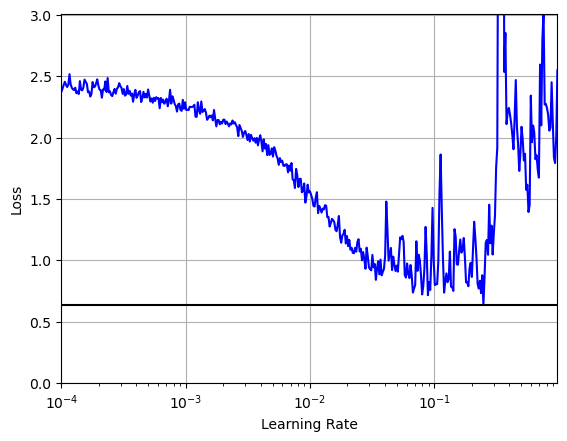

In [22]:


K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor  # ÌïôÏäµÎ•† Ï¶ùÍ∞Ä Í≥ÑÏàò
        self.rates = []       # ÌïôÏäµÎ•† Í∏∞Î°ù
        self.losses = []      # Î∞∞Ïπò ÏÜêÏã§ Í∏∞Î°ù

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0  # ÏóêÌè¨ÌÅ¨ ÏÜêÏã§ Ï¥àÍ∏∞Ìôî

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # ÌòÑÏû¨ÍπåÏßÄ ÌèâÍ∑† ÏÜêÏã§
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)  # ÎàÑÏ†Å ÏÜêÏã§ Ìï© Í≥ÑÏÇ∞
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses  # Î∞∞Ïπò ÏÜêÏã§ Í≥ÑÏÇ∞
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))  # ÌïôÏäµÎ•† Ï†ÄÏû•
        self.losses.append(batch_loss)  # Î∞∞Ïπò ÏÜêÏã§ Ï†ÄÏû•
        
        self.model.optimizer.learning_rate.assign(self.model.optimizer.learning_rate * self.factor)  # ÌïôÏäµÎ•† Ï¶ùÍ∞Ä


def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4, max_rate=1):
    init_weights = model.get_weights()  # Ï¥àÍ∏∞ Í∞ÄÏ§ëÏπò Ï†ÄÏû•
    iterations = math.ceil(len(X) / batch_size) * epochs  # Ï¥ù Î∞∞Ïπò Ïàò Í≥ÑÏÇ∞
    factor = (max_rate / min_rate) ** (1 / iterations)  # ÌïôÏäµÎ•† Ï¶ùÍ∞Ä Í≥ÑÏàò Í≥ÑÏÇ∞
    init_lr = K.get_value(model.optimizer.learning_rate)  # Ï¥àÍ∏∞ ÌïôÏäµÎ•† Ï†ÄÏû•
    model.optimizer.learning_rate.assign(min_rate)  # Ï¥àÍ∏∞ ÌïôÏäµÎ•† ÏÑ§Ï†ï
    exp_lr = ExponentialLearningRate(factor)  # ÏΩúÎ∞± ÏÉùÏÑ±
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])  # ÌïôÏäµ ÏßÑÌñâ
    model.optimizer.learning_rate.assign(init_lr)  # Ï¥àÍ∏∞ ÌïôÏäµÎ•† Î≥µÏõê
    model.set_weights(init_weights)  # Î™®Îç∏ Í∞ÄÏ§ëÏπò Î≥µÏõê
    return exp_lr.rates, exp_lr.losses  # ÌïôÏäµÎ•†Í≥º ÏÜêÏã§ Î∞òÌôò

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')  # ÌïôÏäµÎ•†ÏùÑ Î°úÍ∑∏ Ïä§ÏºÄÏùºÎ°ú ÏÑ§Ï†ï
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")  # ÏµúÏÜå ÏÜêÏã§ ÎùºÏù∏ ÌëúÏãú
    plt.axis([min(rates), max(rates), 0, max_loss])  # Í∑∏ÎûòÌîÑ Ï∂ï Î≤îÏúÑ ÏÑ§Ï†ï
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.grid()
    
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)


In [27]:
model = build_model()

model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 532us/step - accuracy: 0.6926 - loss: 0.9356 - val_accuracy: 0.8260 - val_loss: 0.4940 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 456us/step - accuracy: 0.8306 - loss: 0.4851 - val_accuracy: 0.8426 - val_loss: 0.4420 - learning_rate: 0.0100
Epoch 3/25
1719/1719 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 451us/step - accuracy: 0.8486 - loss: 0.4307 - val_accuracy: 0.8506 - val_loss: 0.4161 - learning_rate: 0.0100
Epoch 4/25
1719/1719 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 459us/step - accuracy: 0.8576 - loss: 0.4000 - val_accuracy: 0.8536 - val_loss: 0.4055 - learning_rate: 0.0100
Epoch 5/25
1719/1719 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 425us/step - accuracy: 0.8647 - loss: 0.3780 - val_accuracy: 0.8560 - val_loss: 0.3982 - learning_rate: 0.0100
Epoch 6/25
1719/1719

In [28]:
"""
1. Ï¥àÍ∏∞ Íµ¨Í∞ÑÏóêÏÑúÎäî ÌïôÏäµÎ•†ÏùÑ ÏÑ†ÌòïÏ†ÅÏúºÎ°ú Ï¶ùÍ∞Ä.
2. Ï§ëÍ∞Ñ Íµ¨Í∞ÑÏóêÏÑúÎäî ÌïôÏäµÎ•†ÏùÑ ÏÑ†ÌòïÏ†ÅÏúºÎ°ú Í∞êÏÜå.
3. ÎßàÏßÄÎßâ Íµ¨Í∞ÑÏóêÏÑúÎäî ÌïôÏäµÎ•†ÏùÑ Í∑πÎèÑÎ°ú ÎÇÆÏùÄ Í∞íÏúºÎ°ú Ï§ÑÏûÑ.
"""
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        """
        OneCycle ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨ Ï¥àÍ∏∞Ìôî.

        Args:
            iterations (int): Ï¥ù Î∞∞Ïπò Ïàò. (Ïòà: steps_per_epoch * epochs)
                             ÏòàÏãú: len(X_train) / batch_size * n_epochs = 500 * 10 = 5000
            max_lr (float): ÌïôÏäµÎ•†Ïùò ÏµúÎåÄÍ∞í (Peak Learning Rate).
                            ÏòàÏãú: 0.2
            start_lr (float, optional): ÌïôÏäµÎ•† ÏãúÏûëÍ∞í (Warm-upÏùò Ï¥àÍ∏∞Í∞í). Í∏∞Î≥∏Í∞íÏùÄ max_lr / 10.
                                        ÏòàÏãú: max_lr=0.2Ïù¥Î©¥ start_lr=0.02.
            last_iterations (int, optional): ÎßàÏßÄÎßâ ÌïôÏäµÎ•† Îã®Í≥ÑÏùò Î∞∞Ïπò Ïàò. Í∏∞Î≥∏Í∞íÏùÄ Ï¥ù Î∞∞Ïπò ÏàòÏùò 10%.
                                              ÏòàÏãú: iterations=5000Ïù¥Î©¥ last_iterations=500.
            last_lr (float, optional): ÎßàÏßÄÎßâ ÌïôÏäµÎ•†Ïùò Í∞í. Í∏∞Î≥∏Í∞íÏùÄ start_lr / 1000.
                                       ÏòàÏãú: start_lr=0.02Ïù¥Î©¥ last_lr=0.00002.
        """
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10  # Ï¥àÍ∏∞ ÌïôÏäµÎ•† (Í∏∞Î≥∏Í∞íÏùÄ max_lrÏùò 1/10)
        self.last_iterations = last_iterations or iterations // 10 + 1 # ÎßàÏßÄÎßâ Íµ¨Í∞Ñ Î∞∞Ïπò Ïàò
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.„Ö† = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        """
        Îëê ÌïôÏäµÎ•† Í∞í ÏÇ¨Ïù¥Î•º (interpolation).

        Args:
            iter1 (int): ÏãúÏûë Î∞∞Ïπò Î≤àÌò∏.
            iter2 (int): Ï¢ÖÎ£å Î∞∞Ïπò Î≤àÌò∏.
            lr1 (float): ÏãúÏûë ÌïôÏäµÎ•† Í∞í.
            lr2 (float): Ï¢ÖÎ£å ÌïôÏäµÎ•† Í∞í.

        Returns:
            float: ÌòÑÏû¨ Î∞∞ÏπòÏóê Ìï¥ÎãπÌïòÎäî ÌïôÏäµÎ•†.
        """
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate.assign(lr)
        
        
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.2)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1ms/step - accuracy: 0.6461 - loss: 1.0840 - val_accuracy: 0.7956 - val_loss: 0.5743
Epoch 2/25
430/430 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 878us/step - accuracy: 0.8108 - loss: 0.5395 - val_accuracy: 0.8158 - val_loss: 0.5123
Epoch 3/25
430/430 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 836us/step - accuracy: 0.8356 - loss: 0.4645 - val_accuracy: 0.8190 - val_loss: 0.5025
Epoch 4/25
430/430 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 846us/step - accuracy: 0.8473 - loss: 0.4254 - val_accuracy: 0.8202 - val_loss: 0.4954
Epoch 5/25
430/430 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 840us/step - accuracy: 0.8566 - loss: 0.3985 - val_accuracy: 0.8294 - val_loss: 0.4722
Epoch 6/25
430/430 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 834us/step - accuracy: 0.8622 - loss: 0.3788 - val_accuracy: 0.8274 -

### 7. Customized Loss&Metric Function

- **Class-Balanced Binary Cross-Entropy (CB-BCE)**
  - ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Î¨∏Ï†úÎ•º Ìï¥Í≤∞ÌïòÍ∏∞ ÏúÑÌï¥ ÎùºÎ≤® ÎπàÎèÑÏóê Îî∞Îùº Í∞ÄÏ§ëÏπòÎ•º Ï†ÅÏö©.
    $$
        \text{CB-BCE} = - w_i \cdot \left( y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right)
    $$

$$
w_i = \frac{1 - \beta}{1 - \beta^{n_i}}
$$

- **Ranking Loss**

  - ÎùºÎ≤® Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ•º Î∞òÏòÅÌïòÏó¨, Ïò¨Î∞îÎ•∏ ÎùºÎ≤®Ïùò Ï†êÏàòÍ∞Ä ÏûòÎ™ªÎêú ÎùºÎ≤®Ïùò Ï†êÏàòÎ≥¥Îã§ ÎÜíÎèÑÎ°ù ÌïôÏäµ.
    $$
    \text{Ranking Loss} = \sum_{i,j} \max(0, \text{margin} - (\hat{y}_i - \hat{y}_j))
    $$

- **Class-Balanced BCE + Ranking Loss**
  $$
  \text{Final Loss} = \alpha \cdot \text{CB-BCE} + \beta \cdot \text{Ranking Loss}
  $$


| ÌäπÏßï                   | `class_weight`                                                                   | `sample_weight`                                       |
| ---------------------- | -------------------------------------------------------------------------------- | ----------------------------------------------------- |
| **Í∞ÄÏ§ëÏπò Î∂ÄÏó¨ Î∞©Ïãù**   | ÌÅ¥ÎûòÏä§(ÎùºÎ≤®) Îã®ÏúÑÎ°ú Ï†ÅÏö©                                                         | Í∞úÎ≥Ñ ÏÉòÌîå Îã®ÏúÑÎ°ú Ï†ÅÏö©                                 |
| **Ï†ÅÏö© ÎåÄÏÉÅ**          | `y_train`Ïù¥ Ï†ïÏàò(ÎùºÎ≤®)Ïùº ÎïåÎßå ÏÇ¨Ïö© Í∞ÄÎä•                                          | `y_train`Ïù¥ Ïõê-Ìï´ Ïù∏ÏΩîÎî©Ïù¥Ïñ¥ÎèÑ ÏÇ¨Ïö© Í∞ÄÎä•              |
| **Î∂àÍ∑†Ìòï Îç∞Ïù¥ÌÑ∞ ÎåÄÏùë** | Ìïú ÌÅ¥ÎûòÏä§Í∞Ä ÎßéÏùÑ Îïå, Ìï¥Îãπ ÌÅ¥ÎûòÏä§Ïùò Í∞ÄÏ§ëÏπòÎ•º ÎÇÆÏ∂îÍ≥† Ìù¨ÏÜåÌïú ÌÅ¥ÎûòÏä§Ïùò Í∞ÄÏ§ëÏπòÎ•º ÎÜíÏûÑ | Í∞ôÏùÄ ÌÅ¥ÎûòÏä§ ÎÇ¥ÏóêÏÑúÎèÑ ÌäπÏ†ï ÏÉòÌîåÎßå Í∞ïÏ°∞ Í∞ÄÎä•            |
| **ÏÇ¨Ïö© ÏòàÏãú**          | ÌÅ¥ÎûòÏä§ 0: 90%, ÌÅ¥ÎûòÏä§ 1: 10% ‚Üí ÌÅ¥ÎûòÏä§ 1Ïóê Îçî ÎÜíÏùÄ Í∞ÄÏ§ëÏπò Î∂ÄÏó¨                    | ÌÅ¥ÎûòÏä§ 1 ÎÇ¥ÏóêÏÑúÎèÑ Ï§ëÏöîÌïú ÏÉòÌîåÏóêÎßå Îçî ÎÜíÏùÄ Í∞ÄÏ§ëÏπò Î∂ÄÏó¨ |
| **Ï†ÅÏö© Î∞©Î≤ï**          | `class_weight={0: 1.0, 1: 10.0}`                                                 | `sample_weight=[1.0, 0.5, 2.0, ...]`                  |


In [4]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn


class HuberMetric(tf.keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='custom_huber_metric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    
    # Ìïú Î∞∞Ïπò(batch)ÎßàÎã§ Î©îÌä∏Î¶≠ Í∞í ÏóÖÎç∞Ïù¥Ìä∏
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}
    
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=10,
                    sample_weight=sample_weight)

(history.history["loss"][0],
 history.history["custom_huber_metric"][0] * sample_weight.mean())

model.save("./120/my_model_with_a_custom_metric.keras")

model = tf.keras.models.load_model(
    "./120/my_model_with_a_custom_metric.keras",
    custom_objects={
        "HuberLoss": HuberLoss,
        "HuberMetric": HuberMetric
    }
)
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/10


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 272us/step - custom_huber_metric: 1.0352 - loss: 0.5071
Epoch 2/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 245us/step - custom_huber_metric: 0.3075 - loss: 0.1548
Epoch 3/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 252us/step - custom_huber_metric: 0.2518 - loss: 0.1265
Epoch 4/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 251us/step - custom_huber_metric: 0.2283 - loss: 0.1149
Epoch 5/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 252us/step - custom_huber_metric: 0.2167 - loss: 0.1091
Epoch 6/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 257us/step - custom_huber_metric: 0.2092 - loss: 0.1053
Epoch 7/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 273us/step - custom_huber_metric: 0.2038 - loss: 0.1026
Epoch 8/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [61]:
history.history

{'custom_huber_metric': [0.6583521962165833,
  0.28962016105651855,
  0.23281827569007874,
  0.2108340561389923,
  0.1999504119157791,
  0.19300642609596252,
  0.18813201785087585,
  0.18409395217895508,
  0.18154661357402802,
  0.1790149211883545],
 'loss': [0.33349132537841797,
  0.14674682915210724,
  0.11791014671325684,
  0.10649929940700531,
  0.10082095116376877,
  0.09718630462884903,
  0.09458249807357788,
  0.0924915000796318,
  0.09113796800374985,
  0.08985715359449387]}

## Custom Model

**`keras.Model`ÏùÑ ÏÉÅÏÜçÌïú Ïª§Ïä§ÌÖÄ Î™®Îç∏ Íµ¨ÏÑ± ÏöîÏÜå**
| Íµ¨ÏÑ± ÏöîÏÜå | ÏÑ§Î™Ö | Ï£ºÏöî Ïó≠Ìï† |
|-----------|--------------------------------|------------------|
| `__init__()` | Î™®Îç∏Ïùò Ï∏µ(layer)Í≥º ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï†ïÏùò | ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨Ï°∞ ÏÉùÏÑ± |
| `call(inputs)` | ÏàúÏ†ÑÌåå(forward pass) Ï†ïÏùò | Îç∞Ïù¥ÌÑ∞ ÏûÖÎ†• ‚Üí Ï∂úÎ†• Î≥ÄÌôò |
| `build(input_shape)` | ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞Î•º Í∏∞Î∞òÏúºÎ°ú Í∞ÄÏ§ëÏπò Ï¥àÍ∏∞Ìôî | Í∞ÄÏ§ëÏπò ÏÉùÏÑ± Î∞è Î∞∞Ïπò ÌÅ¨Í∏∞ Í≥†Î†§ |
| `compile()` | ÏÜêÏã§ Ìï®Ïàò, ÏòµÌã∞ÎßàÏù¥Ï†Ä, ÌèâÍ∞Ä ÏßÄÌëú ÏÑ§Ï†ï | ÌïôÏäµÏùÑ ÏúÑÌïú ÏÑ§Ï†ï |
| `fit()` | Îç∞Ïù¥ÌÑ∞ ÌïôÏäµ | Î™®Îç∏ ÌõàÎ†® Ïã§Ìñâ |
| `evaluate()` | ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÌèâÍ∞Ä | Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä |
| `predict()` | ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° | ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÏòàÏ∏° |
| `get_config()` | Î™®Îç∏ Ï†ÄÏû• Î∞è Î°úÎìú Ïãú ÏÑ§Ï†ï Ïú†ÏßÄ | Î™®Îç∏ ÏßÅÎ†¨Ìôî ÏßÄÏõê |

---


## Í∞ôÏùÄÌï®Ïàò


In [90]:
from keras.utils import plot_model

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)


tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Define layers
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate() # this layer connect two dense layers horizontally
output_layer = tf.keras.layers.Dense(1)

# Construct the functional model
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2]) # short path from input to hidden2 layer
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

model.summary()

model.compile(loss=HuberLoss(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=10,
                    sample_weight=sample_weight)

(history.history["loss"][0],
 history.history["custom_huber_metric"][0] * sample_weight.mean())


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer         ‚îÇ (None, 8)         ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ normalization       ‚îÇ (None, 8)         ‚îÇ         17 ‚îÇ input_layer[0][0] ‚îÇ
‚îÇ (Normalization)     ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)       ‚îÇ (None, 30)        ‚îÇ        270 ‚îÇ normalization[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)     ‚îÇ (None, 30)        ‚îÇ        930 ‚îÇ dense[0][0]       ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ concatenate         ‚îÇ (None, 38)        ‚îÇ          0 ‚îÇ normalization[0]‚Ä¶ ‚îÇ
‚îÇ (Concatenate)       ‚îÇ                   ‚îÇ            ‚îÇ dense_1[0][0]     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)     ‚îÇ (None, 1)         ‚îÇ         39 ‚îÇ concatenate[0][0] ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

Epoch 1/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 450us/step - custom_huber_metric: 1.0809 - loss: 0.5299
Epoch 2/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 630us/step - custom_huber_metric: 0.6882 - loss: 0.3384
Epoch 3/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 377us/step - custom_huber_metric: 0.6723 - loss: 0.3307
Epoch 4/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 412us/step - custom_huber_metric: 0.6678 - loss: 0.3284
Epoch 5/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 346us/step - custom_huber_metric: 0.6663 - loss: 0.3276
Epoch 6/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 333us/step - custom_huber_metric: 0.6657 - loss: 0.3273
Epoch 7/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 324us/step - custom_huber_metric: 0.6653 - loss: 0.3271
Epoch 8/10
363/363 ‚îÅ‚îÅ‚î

(0.40507376194000244, np.float64(0.40767815774937904))

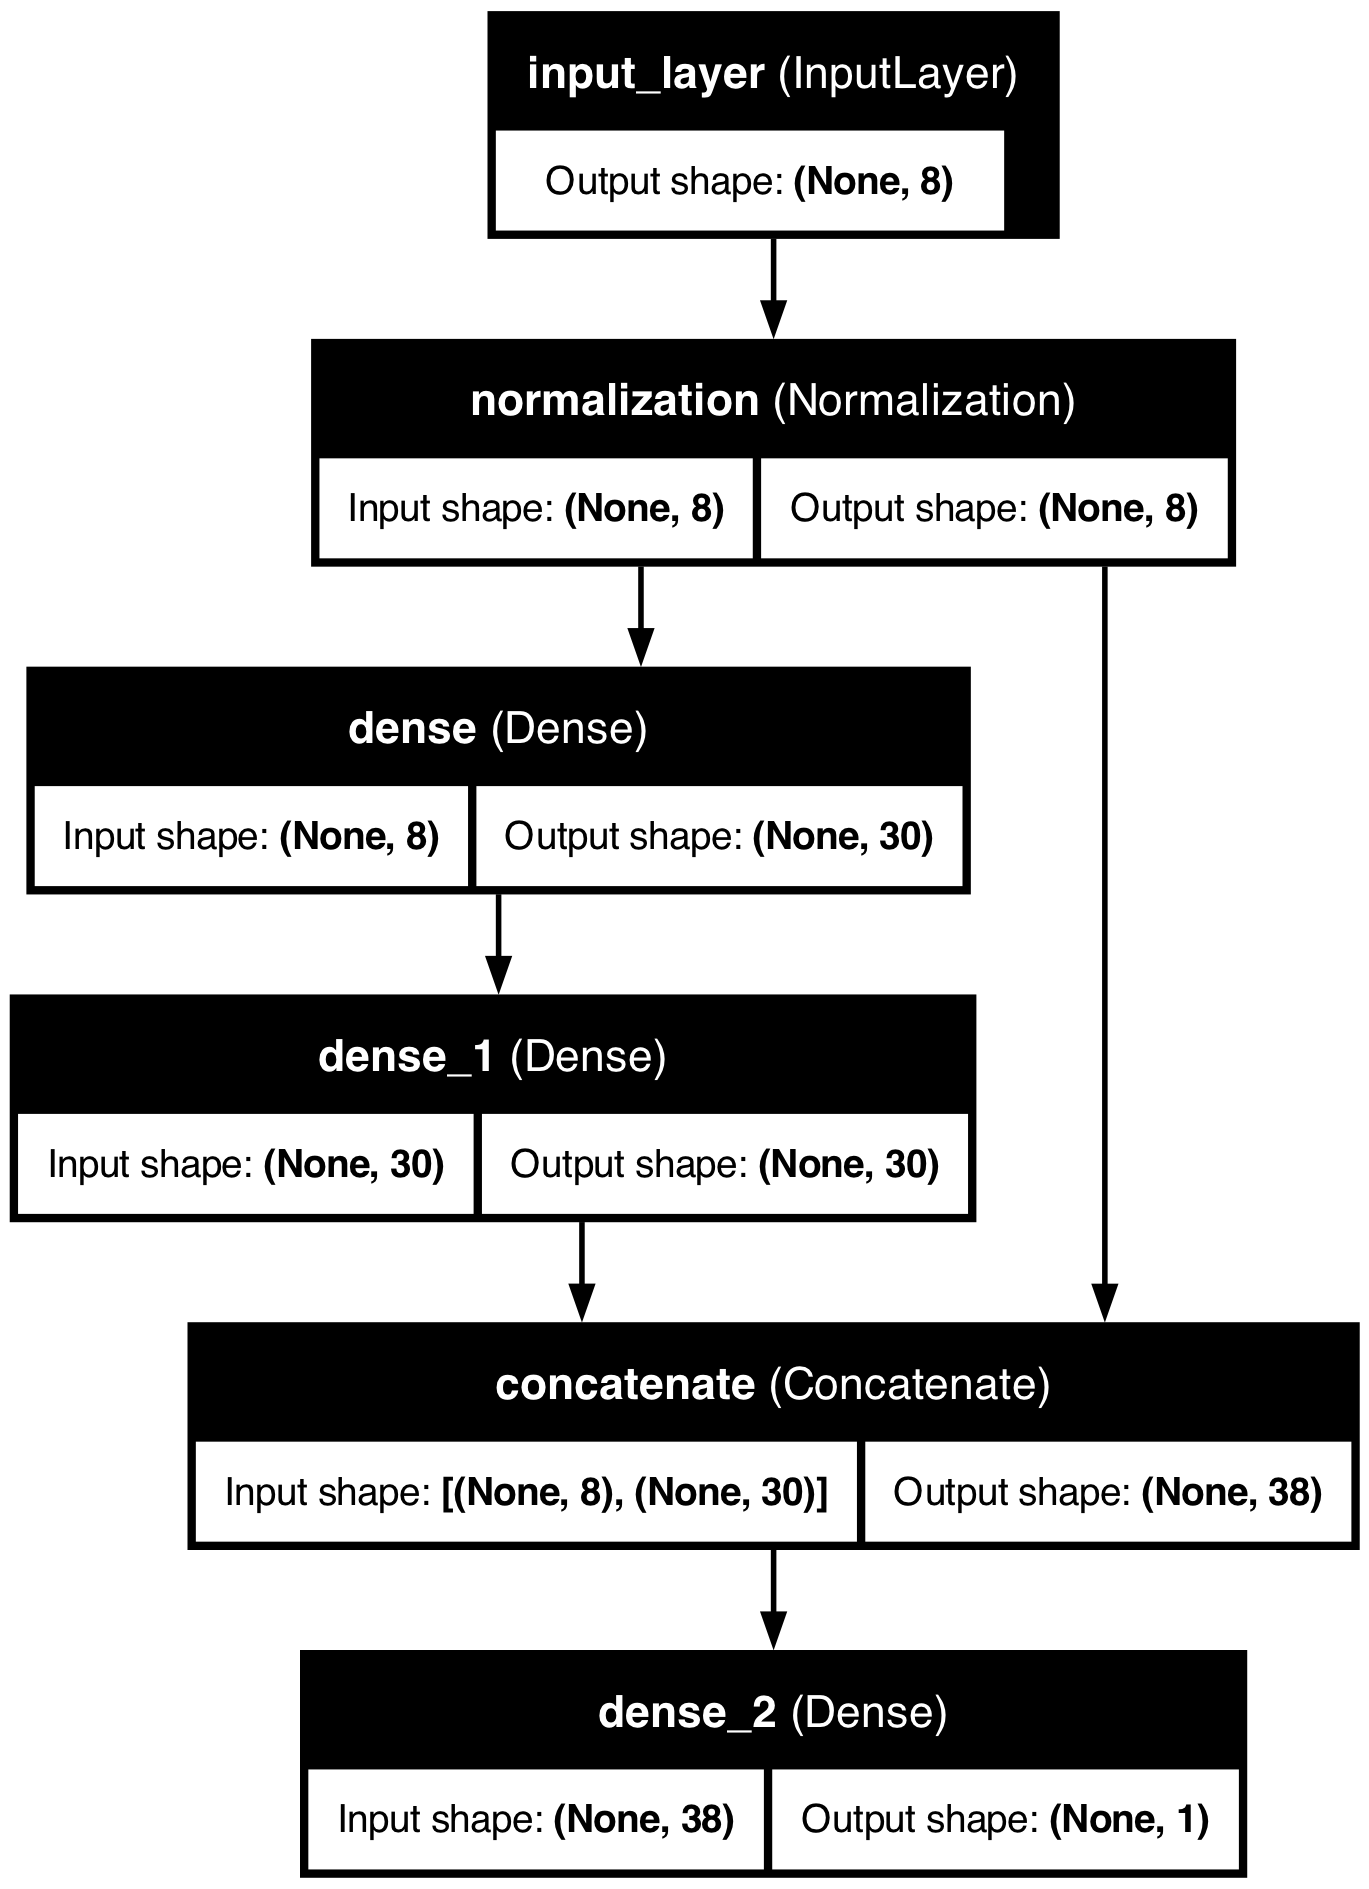

In [91]:
# Î™®Îç∏ Í∑∏Î¶¨Í∏∞
plot_model(model, to_file='./100/functional_API_short_path.png', show_shapes=True, show_layer_names=True)

In [5]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import os
import numpy as np
import random

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   tf.keras.utils.set_random_seed(42)
   random.seed(2)

#make some random data
reset_random_seeds()

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

tf.keras.backend.clear_session()


# Ïª§Ïä§ÌÖÄ Î™®Îç∏ Ï†ïÏùò
class CustomHousingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.input_layer = tf.keras.layers.InputLayer(shape=(8,))  # üîπ ÏûÖÎ†• ÌÅ¨Í∏∞ ÏßÄÏ†ï
        self.normalization = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu")
        self.hidden2 = tf.keras.layers.Dense(30, activation="relu")
        self.concat = tf.keras.layers.Concatenate()
        self.output_layer = tf.keras.layers.Dense(1)

    def build(self, input_shape):
        """Î†àÏù¥Ïñ¥Îì§Ïùò ÏûÖÎ†• ÌÅ¨Í∏∞Î•º Î™ÖÏãúÏ†ÅÏúºÎ°ú Ï†ïÏùò"""
        self.normalization.build(input_shape)  # Ï†ïÍ∑úÌôî Î†àÏù¥Ïñ¥ ÎπåÎìú
        self.hidden1.build(input_shape)  # Ï≤´ Î≤àÏß∏ Dense Î†àÏù¥Ïñ¥ ÎπåÎìú
        self.hidden2.build((None, 30))  # Îëê Î≤àÏß∏ Dense Î†àÏù¥Ïñ¥ ÎπåÎìú
        self.concat.build([(None, 8), (None, 30)])
        self.output_layer.build((None, 38))  # Concatenate Ïù¥ÌõÑ ÌÅ¨Í∏∞ (8 + 30)

        # Î™®Îç∏Ïù¥ ÎπåÎìúÎêòÏóàÏùåÏùÑ ÏÑ†Ïñ∏
        self.built = True
        
    def call(self, inputs):
        normalized = self.normalization(inputs)  # Ï†ïÍ∑úÌôî
        hidden1 = self.hidden1(normalized)  # Ï≤´ Î≤àÏß∏ ÏùÄÎãâÏ∏µ
        hidden2 = self.hidden2(hidden1)  # Îëê Î≤àÏß∏ ÏùÄÎãâÏ∏µ
        concat = self.concat([normalized, hidden2])  # Shortcut Ïó∞Í≤∞
        output = self.output_layer(concat)  # ÏµúÏ¢Ö Ï∂úÎ†•Ï∏µ
        return output

# Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ±
custom_model = CustomHousingModel()

# Î™®Îç∏ ÎπåÎìú (ÏûÖÎ†• ÌÅ¨Í∏∞ ÏßÄÏ†ï)
custom_model.build(input_shape=(None, X_train.shape[1]))

# Î™®Îç∏ ÏöîÏïΩ Ï∂úÎ†•
custom_model.summary()

custom_model.compile(loss=HuberLoss(2.0), optimizer="adam",
              metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = custom_model.fit(X_train_scaled, y_train, epochs=10,
                    sample_weight=sample_weight)

(history.history["loss"][0],
 history.history["custom_huber_metric"][0] * sample_weight.mean())



Model: "custom_housing_model"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer (InputLayer)        ‚îÇ (None, 8)              ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ normalization (Normalization)   ‚îÇ (None, 8)              ‚îÇ            17 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 30)             ‚îÇ           270 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 30)             ‚îÇ           930 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ concatenate (Concatenate)       ‚îÇ (None, 38)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            39 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

Epoch 1/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 302us/step - custom_huber_metric: 1.0797 - loss: 0.5343
Epoch 2/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 263us/step - custom_huber_metric: 0.6950 - loss: 0.3451
Epoch 3/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 266us/step - custom_huber_metric: 0.6735 - loss: 0.3344
Epoch 4/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 267us/step - custom_huber_metric: 0.6673 - loss: 0.3311
Epoch 5/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 273us/step - custom_huber_metric: 0.6652 - loss: 0.3301
Epoch 6/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 271us/step - custom_huber_metric: 0.6646 - loss: 0.3298
Epoch 7/10
363/363 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 283us/step - custom_huber_metric: 0.6636 - loss: 0.3293
Epoch 8/10
363/363 ‚îÅ‚îÅ‚î

(0.4068768620491028, np.float64(0.4077518466796753))

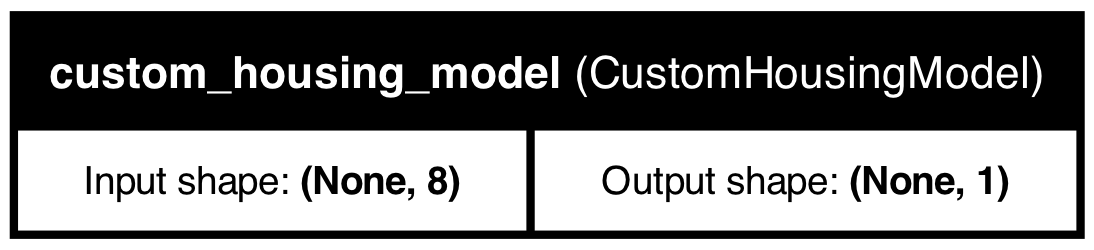

In [10]:
from keras.utils import plot_model
_ = custom_model(tf.keras.Input(shape=(8,)))  # Í∞ÄÏßú ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ ÌùêÎ¶Ñ ÏÉùÏÑ±

# Î™®Îç∏ Í∑∏Î¶¨Í∏∞
plot_model(custom_model, to_file='./100/custom_functional_API_short_path.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)


# Ï∂îÍ∞Ä ÏΩîÎìú - Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ 20Í∞ú ÌååÏùºÎ°ú Î∂ÑÌï†ÌïòÏó¨ CSV ÌååÏùºÎ°ú Ï†ÄÏû•Ìï©ÎãàÎã§.

import numpy as np # type: ignore
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    # 1. Define the directory path where the CSV files will be saved
    housing_dir = Path("./130/") / "datasets" / "housing" #    The directory structure is "./130/datasets/housing".
    housing_dir.mkdir(parents=True, exist_ok=True) # 2. Create the directory (including any necessary parent directories) if it doesn't already exist.
    
    # 3. Define the naming format for the CSV files.
    #    Each file will follow the format "my_<name_prefix>_<file_index>.csv".
    filename_format = "my_{}_{:02d}.csv" # format rules after ":", fill 0, minium 2 digis, d for integers

    # 4. Initialize an empty list to store the file paths of the created CSV files.
    filepaths = []
    # 5. Determine the total number of rows in the data.
    m = len(data)
    # 6. Split the indices of the data into 'n_parts' chunks to divide the dataset evenly.
    chunks = np.array_split(np.arange(m), n_parts)

    # 7. Loop over each chunk to save the corresponding rows into a separate CSV file.
    for file_idx, row_indices in enumerate(chunks):
        # 8. Generate the file path for the current chunk using the naming format.
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        # 9. Append the generated file path to the filepaths list for later reference.
        filepaths.append(str(part_csv))
        
        # 10. Open the file in write mode and write the data.
        with open(part_csv, "w") as f:
            # 11. If a header is provided, write it as the first line of the file.
            if header is not None:
                f.write(header)
                f.write("\n")
            # 12. Write each row of data in the current chunk as a comma-separated line.
            for row_idx in row_indices:
                f.write(",".join([str(col) for col in data[row_idx]]))
                f.write("\n")
    
    # 13. Return the list of file paths for the created CSV files.
    return filepaths


train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)


"""
tf.data.Dataset.list_files: ÌååÏùº Í≤ΩÎ°úÎ•º Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú Î≥ÄÌôò.
TextLineDataset: ÌååÏùº ÎÇ¥Ïö©ÏùÑ ÌÖçÏä§Ìä∏ ÎùºÏù∏ Îã®ÏúÑÎ°ú ÏùΩÏñ¥ Ï≤òÎ¶¨.
skip(1): Ìó§Îçî Ï†úÍ±∞.
interleave: Ïó¨Îü¨ ÌååÏùºÏùÑ Î≥ëÎ†¨Î°ú ÏùΩÍ≥†, Îç∞Ïù¥ÌÑ∞Î•º ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú Í≤∞Ìï©.
"""
random_seed = 42

filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed = random_seed)

for item in filepath_dataset:
    print(item)
    
    



from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_mean, X_std = scaler.mean_, scaler.scale_
n_inputs = 8

"""
parse_csv_line
    Î™©Ï†Å: CSV ÌååÏùºÏùò Í∞Å Ïó¥Ïóê ÎåÄÌïú Í∏∞Î≥∏Í∞í(record_defaults)ÏùÑ Ï†ïÏùò
    Íµ¨Ï°∞:
        [0.] * n_inputs: ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞(X)Ïóê ÎåÄÌï¥ Í∏∞Î≥∏Í∞íÏùÑ 0.0ÏúºÎ°ú ÏÑ§Ï†ï.
        n_inputs: CSV ÌååÏùºÏùò ÏûÖÎ†• ÌîºÏ≤ò Í∞úÏàòÎ•º ÎÇòÌÉÄÎÉÑ.
        [tf.constant([], dtype=tf.float32)]: Ï∂úÎ†• Îç∞Ïù¥ÌÑ∞(y)Ïóê ÎåÄÌï¥ Í∏∞Î≥∏Í∞íÏùÑ Îπà ÌÖêÏÑú([])Î°ú ÏÑ§Ï†ï.
        Îπà ÌÖêÏÑúÎäî Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÏùÑ Îïå Ìï¥Îãπ ÏúÑÏπòÎ•º Ï±ÑÏö∏ Ïàò ÏûàÎèÑÎ°ù gka,
    ÏòàÏ†ú:
        line = "1.0,2.0,3.0,4.0", defs = [0.0, 0.0, 0.0, tf.constant([], dtype=tf.float32)]
        Í≤∞Í≥º: [1.0, 2.0, 3.0, 4.0] (1D ÌÖêÏÑú ÌòïÌÉú).
        
"""
def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype = tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)  # Ïä§ÏπºÎùº ÌÖêÏÑú Î∞òÌôò
    # fields = [tf.Tensor(4.5), tf.Tensor(3.2), ..., tf.Tensor(4.8), tf.Tensor(1.0)]
    
    
    #X = tf.stack([4.5, 3.2, 6.8, 2.1, 5.5, 7.2, 3.6, 4.8])
    #y = tf.stack([1.0])
    return tf.stack(fields[:-1]), tf.stack(fields[-1:]) # stack makes field to 1D tensor

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')



"""
Parameters
    - filepaths: ÏùΩÏñ¥Îì§Ïùº CSV ÌååÏùºÎì§Ïùò Í≤ΩÎ°ú Î¶¨Ïä§Ìä∏. Ïòà: ["file1.csv", "file2.csv"].
    - n_readers: ÎèôÏãúÏóê ÏùΩÏùÑ ÌååÏùº Í∞úÏàò. Î≥ëÎ†¨Ï†ÅÏúºÎ°ú Îç∞Ïù¥ÌÑ∞Î•º ÏùΩÏñ¥ ÏÑ±Îä•ÏùÑ Ìñ•ÏÉÅ.
    - n_read_threads: ÌååÏùº ÏùΩÍ∏∞ ÏûëÏóÖÏóê ÏÇ¨Ïö©Ìï† Ïì∞Î†àÎìú Ïàò. Í∏∞Î≥∏Í∞í NoneÏù∏ Í≤ΩÏö∞ TensorFlowÍ∞Ä ÏûêÎèôÏúºÎ°ú ÏµúÏ†ÅÏùò Ïì∞Î†àÎìú ÏàòÎ•º ÏÑ§Ï†ï.
    - n_parse_threads: Îç∞Ïù¥ÌÑ∞ ÌååÏã±Ïóê ÏÇ¨Ïö©Ìï† Ïì∞Î†àÎìú Ïàò.
    - shuffle_buffer_size: Îç∞Ïù¥ÌÑ∞ ÏÑûÍ∏∞(shuffling)Ïóê ÏÇ¨Ïö©Ìï† Î≤ÑÌçº ÌÅ¨Í∏∞. ÌÅ¥ÏàòÎ°ù Îçî Ïûò ÏÑûÏù¥ÏßÄÎßå Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Ï¶ùÍ∞Ä.
    - seed: ÎûúÎç§ ÏãúÎìú Í∞í. ÎèôÏùºÌïú ÏàúÏÑúÎ•º Ïû¨ÌòÑÌï† Ïàò ÏûàÏùå.
    - batch_size: Îç∞Ïù¥ÌÑ∞ Î∞∞Ïπò ÌÅ¨Í∏∞. Ìïú Î≤àÏóê Î∞òÌôòÌï† Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå Ïàò.
"""

def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=tf.data.AUTOTUNE,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32, repeat = True):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed) # Ï£ºÏñ¥ÏßÑ ÌååÏùº Í≤ΩÎ°ú(filepaths)Î•º Í∏∞Î∞òÏúºÎ°ú ÎûúÎç§ÌïòÍ≤å ÏÑûÏù∏ Îç∞Ïù¥ÌÑ∞ÏÖã
    """
    interleave:
        Ïó¨Îü¨ ÌååÏùºÏùÑ Î≥ëÎ†¨Î°ú ÏùΩÍ≥† Îç∞Ïù¥ÌÑ∞Î•º Í≤∞Ìï©.
        cycle_length=n_readers: ÎèôÏãúÏóê ÏùΩÏùÑ ÌååÏùº Ïàò.
        num_parallel_calls=n_read_threads: Î≥ëÎ†¨Î°ú ÏùΩÍ∏∞ ÏúÑÌïú Ïì∞Î†àÎìú Ïàò.
        tf.data.TextLineDataset(filepath).skip(1):

        CSV ÌååÏùºÏùÑ Ìïú Ï§ÑÏî© ÏùΩÎäî Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±.
        .skip(1): CSV ÌååÏùºÏùò Ìó§Îçî(Ï≤´ Î≤àÏß∏ Ï§Ñ)Î•º Í±¥ÎÑàÎúÄ.
    """
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads)
    
    """
    map(preprocess):
        preprocess Ìï®ÏàòÎ•º ÏÇ¨Ïö©Ìï¥ Í∞Å Ï§Ñ Îç∞Ïù¥ÌÑ∞Î•º Ï†ÑÏ≤òÎ¶¨.
        num_parallel_calls=n_parse_threads: Ïó¨Îü¨ Ïì∞Î†àÎìúÏóêÏÑú Î≥ëÎ†¨Î°ú Ï†ÑÏ≤òÎ¶¨ ÏûëÏóÖ ÏàòÌñâ.
        
        preprocessÏùò ÎèôÏûë:
            parse_csv_lineÏúºÎ°ú Îç∞Ïù¥ÌÑ∞Î•º ÌååÏã±ÌïòÏó¨ ÏûÖÎ†•(X)Í≥º Ï∂úÎ†•(y)ÏùÑ ÎÇòÎàî.
            ÏûÖÎ†•(X)ÏùÄ Ï†ïÍ∑úÌôî((x - X_mean) / X_std) ÏàòÌñâ.
    """
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    """
    shuffle:
        Îç∞Ïù¥ÌÑ∞Î•º ÎûúÎç§ÌïòÍ≤å ÏÑûÏñ¥ Î™®Îç∏ ÌïôÏäµÏùò Ìé∏Ìñ•ÏùÑ Î∞©ÏßÄ.
        shuffle_buffer_size=10_000: 10,000Í∞úÏùò Îç∞Ïù¥ÌÑ∞Î•º Î©îÎ™®Î¶¨Ïóê Ïú†ÏßÄÌïòÎ©∞ ÏÑûÏùå.
    """
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    
    """
    batch(batch_size):
        Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÏßÄÏ†ïÎêú ÌÅ¨Í∏∞(batch_size)Î°ú ÎÇòÎàî.
        Ïòà: batch_size=32Ïù¥Î©¥ 32Í∞úÏùò ÏÉòÌîåÏù¥ ÌïòÎÇòÏùò Î∞∞ÏπòÎ°ú Î∞òÌôò.
    
    prefetch(1):
        Îç∞Ïù¥ÌÑ∞Î•º ÎØ∏Î¶¨ Î°úÎìúÌïòÏó¨ Î™®Îç∏ ÌïôÏäµ Ï§ë Îç∞Ïù¥ÌÑ∞ I/O Î≥ëÎ™©ÏùÑ Î∞©ÏßÄ.
        ÌïôÏäµÏù¥ ÏßÑÌñâÎêòÎäî ÎèôÏïà Îã§Ïùå Î∞∞ÏπòÎ•º ÎØ∏Î¶¨ Ï§ÄÎπÑ.

    """
    
    dataset = dataset.batch(batch_size, drop_remainder=False).prefetch(1)
    if repeat:
        dataset = dataset.repeat()
    return dataset


#tf.keras.backend.clear_session()

train_set = csv_reader_dataset(train_filepaths, repeat= True)
valid_set = csv_reader_dataset(valid_filepaths, repeat= True)
test_set = csv_reader_dataset(test_filepaths, repeat=False)

n_train_samples = len(X_train)
n_valid_samples = len(X_valid)

batch_size = 32

steps_per_epoch = n_train_samples // batch_size  # Ìïú ÏóêÌè≠ ÎèôÏïà Ï≤òÎ¶¨Ìï† Î∞∞Ïπò Ïàò
validation_steps = n_valid_samples // batch_size  # Ìïú ÏóêÌè≠ ÎèôÏïà Ï≤òÎ¶¨Ìï† Í≤ÄÏ¶ù Î∞∞Ïπò Ïàò

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = X_train.shape[1:]),
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")


model.fit(train_set,steps_per_epoch = steps_per_epoch,
          validation_data=valid_set, validation_steps= validation_steps,
          epochs=15,
          )


    